In [2]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D

warnings.simplefilter('ignore')

countryName = 'Russia'

nFeatures = 1

nDaysMin = 3
k = 3

nValid = 10
nTest = 10

In [3]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFilename = 'confirmed_july.csv'
deathsFilename = 'deaths_july.csv'
recoveredFilename = 'recovered_july.csv'

In [4]:
confirmed = pd.read_csv(confirmedFilename)

In [5]:
confirmed.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,880,884,884,889,889,897,897,897,907,907
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,705,749,779,812,851,880,916,932,950,1000


In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))
def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [8]:
# Function to get all three frames for a given country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

In [9]:
# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFilename)
covidFrDict['deaths'] = pd.read_csv(deathsFilename)
covidFrDict['recovered'] = pd.read_csv(recoveredFilename)

countryCovidFrDict = getCountryCovidFrDict(countryName)

# date list
colNamesList = list(countryCovidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryCovidFrDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))

# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nFeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nFeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nFeatures))

Total size of data points for LSTM: 128
Size of training set: 108
Size of validation set: 10
Size of test set: 10


# Vanilla LSTM

In [10]:
nNeurons = 100 # number of neurones
nFeatures = 1  # number of features

bestValidMAPE = 100 # 100 validation for best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed

# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredVanilla = yPredListList    

0 99.94567522641144
Updating best MAPE to 99.94567522641144...
Updating best seed to 0...
1 0.6999863978355488
Updating best MAPE to 0.6999863978355488...
Updating best seed to 1...
2 2.0885976105061377
3 1.1888076033081725
4 3.3464136162999054
5 1.4639420510622594
6 1.4606125564272088
7 5.189656749994882
8 3.2498393762017694
9 1.0120792748659544
10 0.6985880021148162
Updating best MAPE to 0.6985880021148162...
Updating best seed to 10...
11 1.7598515558583872
12 9.409306613011834
13 1.9471510563863725
14 1.0092884784363518
15 99.95629109704305
16 1.5806172160953829
17 99.94604295485351
18 2.0390025365670126
19 0.4953066279373198
Updating best MAPE to 0.4953066279373198...
Updating best seed to 19...
20 2.2707247273635223
21 1.733320495406332
22 99.9455654805724
23 0.9896922203016771
24 0.19206214053207668
Updating best MAPE to 0.19206214053207668...
Updating best seed to 24...
25 2.476758402025697
26 2.7949110839138314
27 99.94558940268013
28 3.2499422122956276
29 1.5405796754312941
3

In [11]:
model.summary()

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 100)               40800     
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Stacked LSTM

In [11]:
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
    model.add(LSTM(nNeurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
model.add(LSTM(nNeurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredStacked = yPredListList

0 3.4757039564977776
Updating best MAPE to 3.4757039564977776...
Updating best seed to 0...
1 1.230272018286347
Updating best MAPE to 1.230272018286347...
Updating best seed to 1...
2 0.12607448429220905
Updating best MAPE to 0.12607448429220905...
Updating best seed to 2...
3 4.991200502188097
4 1.9998392712407231
5 0.9747958732800942
6 2.573919319576539
7 62.217850320416346
8 63.83416492475585
9 0.8502744442873901
10 3.773321255262642
11 63.74451561729696
12 4.734590497053769
13 2.233871302801429
14 0.3043902982552888
15 1.254381942508388
16 99.96259320726058
17 2.3398527442982138
18 3.539904005889552
19 0.8454025859958669
20 0.07961972902110209
Updating best MAPE to 0.07961972902110209...
Updating best seed to 20...
21 62.47709537833013
22 64.04374409290506
23 1.4756239284612904
24 0.05315824940477798
Updating best MAPE to 0.05315824940477798...
Updating best seed to 24...
25 64.08951224132535
26 99.96675407328475
27 2.8361268487074613
28 5.483019448897976
29 63.2299085107611
30 2.5

In [13]:
yPredStacked

[[752129.2, 759111.6, 766155.1],
 [758603.1, 765644.8, 772747.7],
 [765052.8, 772153.6, 779315.6],
 [771329.9, 778489.1, 785708.9],
 [777487.25, 784703.4, 791979.4],
 [783449.5, 790721.2, 798051.9],
 [789335.3, 796661.2, 804045.9],
 [795240.1, 802619.94, 810058.8],
 [801125.25, 808558.94, 816051.9],
 [806959.94, 814447.25, 821993.7]]

In [14]:
model.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_301 (LSTM)              (None, 3, 50)             10400     
_________________________________________________________________
lstm_302 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


# Bi-directional LSTM

In [12]:
# define model
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredBidirectional = yPredListList

0 4.554404774354848
Updating best MAPE to 4.554404774354848...
Updating best seed to 0...
1 12.589938416317684
2 3.6087722102772815
Updating best MAPE to 3.6087722102772815...
Updating best seed to 2...
3 3.1814083342629007
Updating best MAPE to 3.1814083342629007...
Updating best seed to 3...
4 3.7525691259033764
5 1.517664749861839
Updating best MAPE to 1.517664749861839...
Updating best seed to 5...
6 1.8128492019615727
7 0.7395754453021611
Updating best MAPE to 0.7395754453021611...
Updating best seed to 7...
8 2.5975023416799297
9 1.3738528622271862
10 0.6055808264632921
Updating best MAPE to 0.6055808264632921...
Updating best seed to 10...
11 1.338485043237843
12 2.341338272187024
13 1.5975635784238904
14 1.1299437653703184
15 2.4868375367763975
16 3.095224577868096
17 4.494678701243345
18 1.4118469786227614
19 3.0398872931409144
20 0.8952836020056836
21 0.1503256271056775
Updating best MAPE to 0.1503256271056775...
Updating best seed to 21...
22 3.0829994280335575
23 99.9484440

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

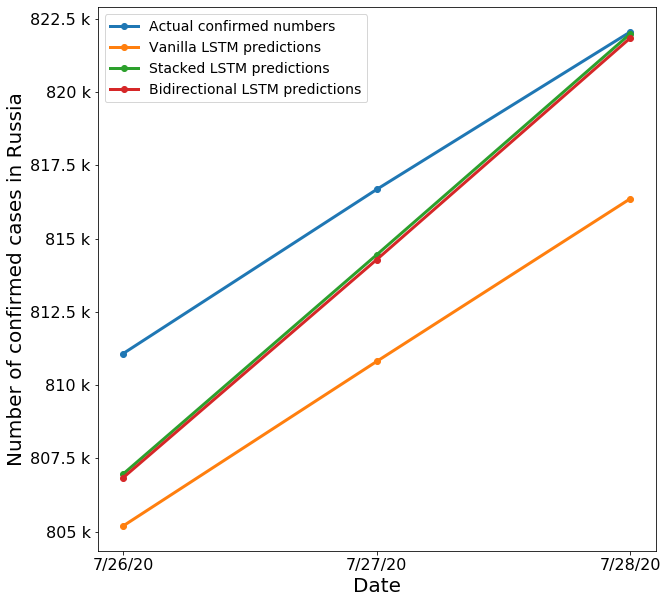

In [14]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Russia', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual confirmed numbers');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k3', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k3', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [18]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)

Test RMSE: 53009.35758812195


In [48]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)

Test RMSE: 5818.70494041361


In [19]:
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)

Test RMSE: 51280.36461931198


In [49]:
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)#Test RMSE: 2702.2739214139942

Test RMSE: 2702.2739214139942


In [20]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)#Test RMSE: 51299.70042122786

Test RMSE: 51299.70042122786


In [50]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)#Test RMSE: 2813.802043286287

Test RMSE: 2813.802043286287


In [21]:
MSE = meanSquaredError(groundTruthList, yPredBidirectional)

In [24]:
MSE

2631659263.307726

In [15]:
groundTruthList

[811073, 816680, 822060]

In [67]:
yPredVanilla[-1]
#[805187.6, 810807.2, 816364.0]

[805187.6, 810807.2, 816364.0]

In [68]:
 yPredStacked[-1]
    #[806959.94, 814447.25, 821993.7]

[806959.94, 814447.25, 821993.7]

In [69]:
yPredBidirectional[-1]
#[806834.75, 814283.0, 821850.06]

[806834.75, 814283.0, 821850.06]

In [65]:
#us
ustable = pd.read_csv('US_RMSE_2.csv')
ustable

,Experiments for US,Vanilla RMSE,Stacked RMSE,BiLSTM RMSE
0,Exp 1,41531.15,45551.60,53594.45
1,Exp 2,42936.06,41820.91,47332.06
2,Exp 3,38833.74,56367.72,229591.44
3,Exp 4,25181.02,25227.20,25305.00


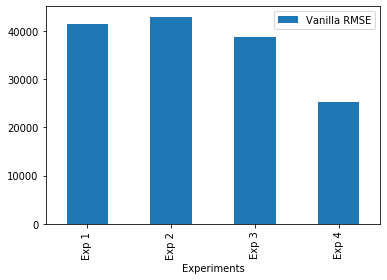

In [52]:
ustable.plot.bar(x = 'Experiments', y = 'Vanilla RMSE')


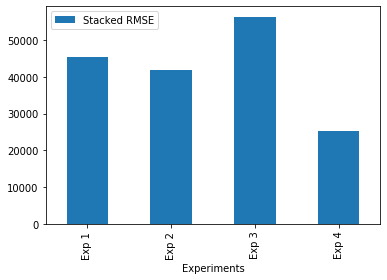

In [53]:
ustable.plot(kind='bar', x = 'Experiments', y = 'Stacked RMSE')

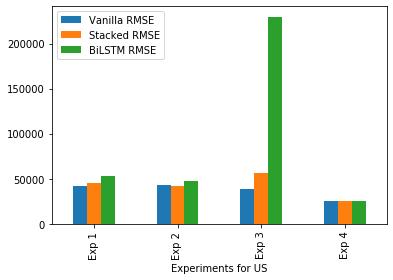

In [66]:
import matplotlib.pyplot as plot

ustable.plot.bar(x = 'Experiments for US')
plot.show(block=True);


In [63]:
braziltable = pd.read_csv('brazil_RMSE_2.csv')

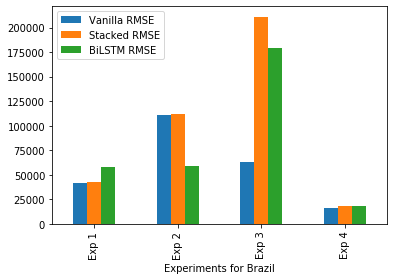

In [64]:

#brazil
braziltable.plot.bar(x = 'Experiments for Brazil')
plot.show(block=True);

In [61]:
#russia
russiatable = pd.read_csv('russia_RMSE_2.csv')

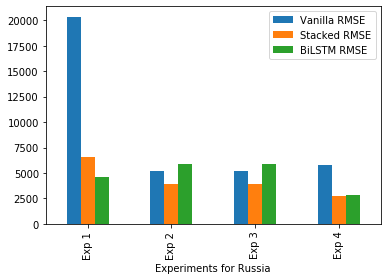

In [62]:
russiatable.plot.bar(x = 'Experiments for Russia')
plot.show(block=True);
